In [1]:
from __future__ import division

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import sys
sys.path.insert(0, '..')

import random
import numpy as np
import pandas as pd
from collections import deque
from scipy.integrate import odeint
from control import lqr

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

from algs.td3 import Agent_TD3
from algs.ppo import Agent_PPO
from envs.env import WoundEnv, SimpleEnv
from cfgs.config import GetParameters

In [2]:
args = GetParameters()
args.figs_dir = '../res/figs/figs_{}/'.format(args.alg_rl)

dirs = [args.model_dir, args.data_dir, args.figs_dir]
for dirtmp in dirs:
    if not os.path.exists(dirtmp):
        os.makedirs(dirtmp)

In [20]:
kh = 0.5
ki = 0.3
kp = 0.1
A = np.array([[-kh, 0, 0, 0],
              [kh, -ki, 0, 0],
              [0, ki, -kp, 0],
              [0, 0, kp, 0]])
x0 = np.array([1, 0, 0, 0]).reshape(-1, 1)
Ts = 0.1
TNum = 600
TScale = 3

In [24]:
x_nontreat_buf = np.zeros([0, 4])

x = x0
for t in range(TNum):
    x_nontreat_buf = np.vstack((x_nontreat_buf, x.reshape(-1)))
    x_1 = x + Ts * A @ x
    x = x_1
heal_day_nontreat = round(np.min(np.where(x_nontreat_buf[:, 3] > 0.95)) * Ts / TScale)

In [25]:
B = np.array([[-1, 0, 0, 0],
              [1, -1, 0, 0],
              [0, 1, -1, 0],
              [0, 0, 1, 0]])
Q = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 0]])
R = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
K, S, E = lqr(A, B, Q, R)

In [27]:
pd.DataFrame(K)

,0,1,2,3
0,-0.535133,0.379027,0.105405,-1.713373e-16
1,-0.322683,-0.596305,0.425991,1.049024e-16
2,-0.272718,-0.378123,-0.804114,3.278867e-17
3,0.000000,0.000000,0.000000,0.000000e+00


In [28]:
pd.DataFrame(-B @ K)

,0,1,2,3
0,-0.535133,0.379027,0.105405,-1.713373e-16
1,0.212450,-0.975331,0.320586,2.762397e-16
2,0.049965,0.218182,-1.230105,-7.211377e-17
3,0.272718,0.378123,0.804114,-3.278867e-17


In [29]:
x_opttreat_buf = np.zeros([0, 4])
u_opttreat_buf = np.zeros([0, 4])
k_act_buf = np.zeros([0, 4])
x = x0
for t in range(TNum):
    u = -K @ x
    x_opttreat_buf = np.vstack((x_opttreat_buf, x.reshape(-1)))
    u_opttreat_buf = np.vstack((u_opttreat_buf, u.reshape(-1)))
    x_1 = x + Ts * (A @ x + B @ u)
    x = x_1
heal_day_optreat = round(np.min(np.where(x_opttreat_buf[:, 3] > 0.95)) * Ts / TScale)

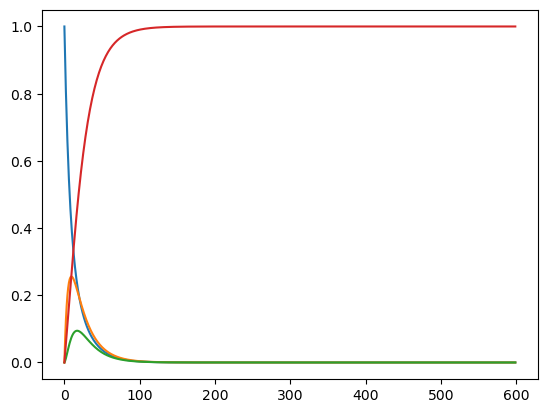

In [30]:
plt.plot(x_opttreat_buf)

In [7]:
print('Optimal Gain is: \n', K)
print('Treat take', heal_day_optreat, 'days')
print('Non Treat take', heal_day_nontreat, 'days')

Optimal Gain is: 
 [[-5.35133163e-01  3.79026645e-01  1.05404965e-01 -1.71337265e-16]
 [-3.22682857e-01 -5.96304537e-01  4.25990772e-01  1.04902436e-16]
 [-2.72718003e-01 -3.78122968e-01 -8.04113740e-01  3.27886656e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Treat take 2 days
Non Treat take 12 days


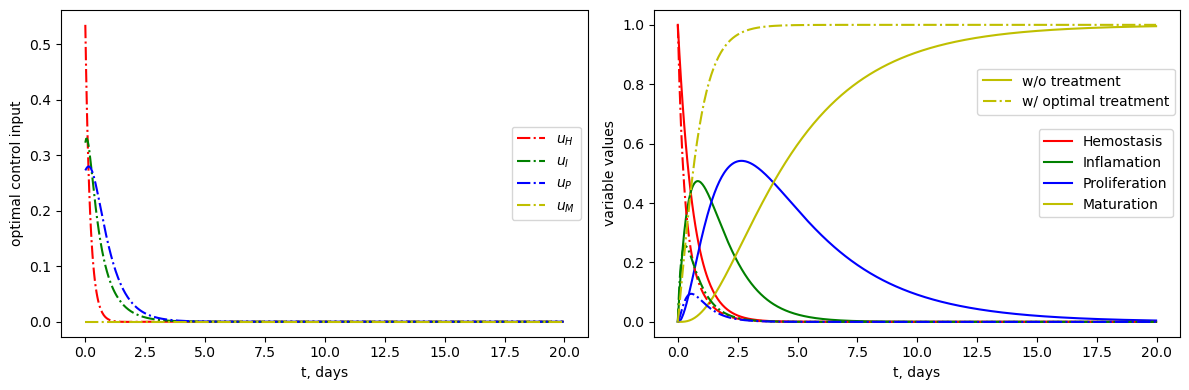

In [8]:
trange = np.arange(TNum) * Ts / TScale
fig = plt.figure(figsize=(12, 4), num=3)

ax = fig.add_subplot(121)
ax.plot(trange, u_opttreat_buf[:, 0], c='r', linestyle='-.', label=r'$u_H$')
ax.plot(trange, u_opttreat_buf[:, 1], c='g', linestyle='-.', label=r'$u_I$')
ax.plot(trange, u_opttreat_buf[:, 2], c='b', linestyle='-.', label=r'$u_P$')
ax.plot(trange, u_opttreat_buf[:, 3], c='y', linestyle='-.', label=r'$u_M$')

ax.set_xlabel('t, days')
ax.set_ylabel('Input')
ax.legend(loc='center right')

ax.set_xlabel('t, days')
ax.set_ylabel('optimal control input')
ax.legend(loc='center right')

lines = []

ax = fig.add_subplot(122)
ax.plot(trange, x_nontreat_buf[:, 0], c='r', linestyle='-', label='Hemostasis')
ax.plot(trange, x_nontreat_buf[:, 1], c='g', linestyle='-', label='Inflamation')
ax.plot(trange, x_nontreat_buf[:, 2], c='b', linestyle='-', label='Proliferation')
lines += ax.plot(trange, x_nontreat_buf[:, 3], c='y', linestyle='-', label='Maturation')

ax.plot(trange, x_opttreat_buf[:, 0], c='r', linestyle='-.')
ax.plot(trange, x_opttreat_buf[:, 1], c='g', linestyle='-.')
ax.plot(trange, x_opttreat_buf[:, 2], c='b', linestyle='-.')
lines += ax.plot(trange, x_opttreat_buf[:, 3], c='y', linestyle='-.')

from matplotlib.legend import Legend
leg = Legend(ax, lines, ['w/o treatment', 'w/ optimal treatment'],
             bbox_to_anchor=(0.99, 0.75), 
             loc='center right', borderaxespad=0, frameon=True)
ax.add_artist(leg)

ax.set_xlabel('t, days')
ax.set_ylabel('variable values')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
ax.legend(loc='center right')
plt.tight_layout()
plt.savefig(args.figs_dir + 'LQR_sultion.pdf', format='pdf')
plt.savefig(args.figs_dir + 'LQR_sultion.svg', format='svg')